# Day 6: Volatility Trading Strategies

## Learning Objectives
- Build volatility-based trading strategies
- Implement volatility timing
- Create volatility regime strategies
- Understand volatility risk premium

## Strategies Covered
- Low volatility anomaly
- Volatility regime switching
- Volatility targeting
- Volatility risk premium harvesting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('../datasets/raw_data')
TRADING_DAYS = 252

df = pd.read_csv(DATA_DIR / 'combined_adjusted_close.csv', index_col='Date', parse_dates=True)
prices = df.ffill().dropna()
returns = prices.pct_change().dropna()

print("="*60)
print("VOLATILITY TRADING STRATEGIES - DAY 6")
print("="*60)
print(f"Data: {len(returns)} days, {len(returns.columns)} assets")

VOLATILITY TRADING STRATEGIES - DAY 6
Data: 1834 days, 63 assets


## 1. Low Volatility Anomaly

In [2]:
# Low volatility stocks tend to outperform on risk-adjusted basis
# Strategy: Long low vol, short high vol

lookback = 60  # 60-day volatility

# Calculate rolling volatility for all stocks
rolling_vol = returns.rolling(lookback).std() * np.sqrt(TRADING_DAYS)

# Remove any assets with too many NaNs
valid_assets = rolling_vol.columns[rolling_vol.isna().sum() < len(rolling_vol) * 0.3]
rolling_vol = rolling_vol[valid_assets]
asset_returns = returns[valid_assets]

# Rank stocks by volatility each day
vol_rank = rolling_vol.rank(axis=1, pct=True)

# Low vol portfolio: bottom 20%
low_vol_mask = vol_rank <= 0.2

# High vol portfolio: top 20%
high_vol_mask = vol_rank >= 0.8

# Equal weight portfolios (handle division by zero)
low_vol_count = low_vol_mask.shift(1).sum(axis=1).replace(0, np.nan)
high_vol_count = high_vol_mask.shift(1).sum(axis=1).replace(0, np.nan)

low_vol_returns = (asset_returns * low_vol_mask.shift(1)).sum(axis=1) / low_vol_count
high_vol_returns = (asset_returns * high_vol_mask.shift(1)).sum(axis=1) / high_vol_count
spread_returns = low_vol_returns - high_vol_returns

# Clean NaN
low_vol_returns = low_vol_returns.dropna()
high_vol_returns = high_vol_returns.dropna()
spread_returns = spread_returns.dropna()

print("\n" + "="*60)
print("LOW VOLATILITY ANOMALY RESULTS")
print("="*60)


LOW VOLATILITY ANOMALY RESULTS


In [3]:
# Performance analysis
def portfolio_stats(returns, name):
    ann_ret = returns.mean() * TRADING_DAYS * 100
    ann_vol = returns.std() * np.sqrt(TRADING_DAYS) * 100
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    cum_ret = (1 + returns).cumprod().iloc[-1] - 1
    max_dd = ((1 + returns).cumprod() / (1 + returns).cumprod().cummax() - 1).min()
    
    return {
        'Portfolio': name,
        'Ann. Return (%)': ann_ret,
        'Ann. Vol (%)': ann_vol,
        'Sharpe': sharpe,
        'Total Return (%)': cum_ret * 100,
        'Max Drawdown (%)': max_dd * 100
    }

results = [
    portfolio_stats(low_vol_returns, 'Low Vol (Bottom 20%)'),
    portfolio_stats(high_vol_returns, 'High Vol (Top 20%)'),
    portfolio_stats(spread_returns, 'Long/Short Spread')
]

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

           Portfolio  Ann. Return (%)  Ann. Vol (%)    Sharpe  Total Return (%)  Max Drawdown (%)
Low Vol (Bottom 20%)         6.761877      7.934260  0.852238         57.424989        -15.821005
  High Vol (Top 20%)        36.297519     45.747246  0.793436        309.004356        -89.602541
   Long/Short Spread       -29.535641     43.479855 -0.679295        -93.010623        -97.294610


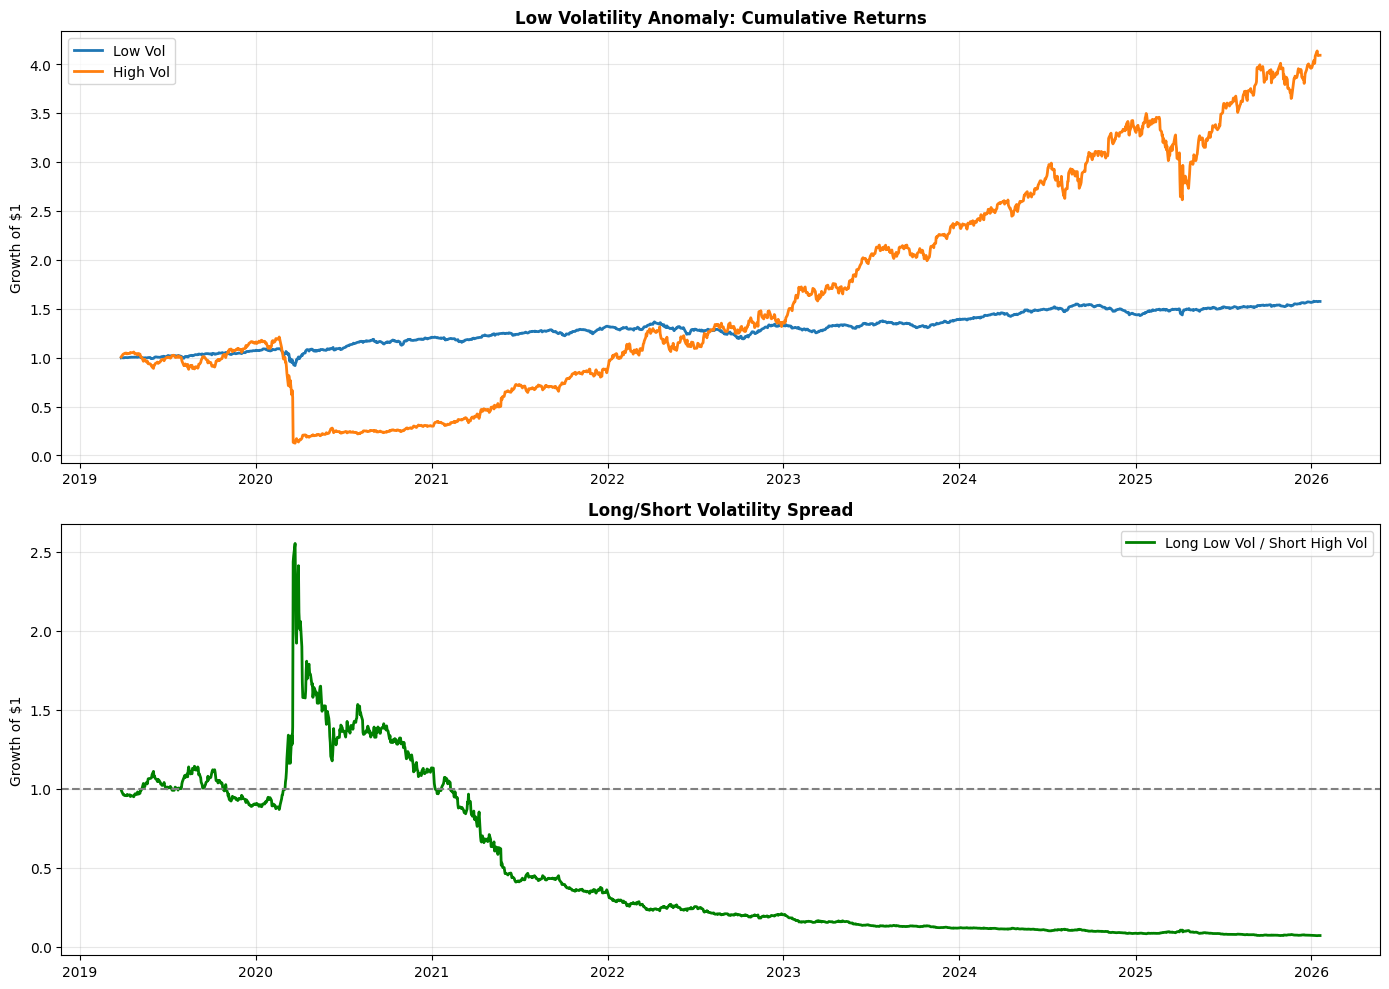

In [4]:
# Plot cumulative returns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

ax1 = axes[0]
ax1.plot((1 + low_vol_returns).cumprod(), label='Low Vol', linewidth=2)
ax1.plot((1 + high_vol_returns).cumprod(), label='High Vol', linewidth=2)
ax1.set_title('Low Volatility Anomaly: Cumulative Returns', fontweight='bold')
ax1.set_ylabel('Growth of $1')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot((1 + spread_returns).cumprod(), label='Long Low Vol / Short High Vol', color='green', linewidth=2)
ax2.axhline(1, color='gray', linestyle='--')
ax2.set_title('Long/Short Volatility Spread', fontweight='bold')
ax2.set_ylabel('Growth of $1')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Volatility Regime Strategy

In [5]:
# Strategy: Reduce exposure in high volatility regimes
spy_returns = returns['SPY'].dropna()
spy_vol = spy_returns.rolling(20).std() * np.sqrt(TRADING_DAYS)

# Define volatility regimes
vol_percentile = spy_vol.rolling(252).apply(lambda x: stats.percentileofscore(x, x.iloc[-1]))

# Regime classification
low_vol_regime = vol_percentile < 30
high_vol_regime = vol_percentile > 70
med_vol_regime = ~low_vol_regime & ~high_vol_regime

print("\n" + "="*60)
print("VOLATILITY REGIME ANALYSIS")
print("="*60)
print(f"Low Vol Regime (<30th %ile):  {low_vol_regime.sum()} days ({low_vol_regime.mean()*100:.1f}%)")
print(f"Med Vol Regime (30-70th %ile): {med_vol_regime.sum()} days ({med_vol_regime.mean()*100:.1f}%)")
print(f"High Vol Regime (>70th %ile): {high_vol_regime.sum()} days ({high_vol_regime.mean()*100:.1f}%)")


VOLATILITY REGIME ANALYSIS
Low Vol Regime (<30th %ile):  575 days (31.4%)
Med Vol Regime (30-70th %ile): 776 days (42.3%)
High Vol Regime (>70th %ile): 483 days (26.3%)


In [6]:
# Strategy weights based on regime
weights = pd.Series(index=spy_returns.index, dtype=float)
weights[low_vol_regime] = 1.5   # Lever up in low vol
weights[med_vol_regime] = 1.0   # Normal exposure
weights[high_vol_regime] = 0.5  # Reduce in high vol

# Shift weights to avoid look-ahead
weights = weights.shift(1)

# Strategy returns
regime_strategy_returns = spy_returns * weights
regime_strategy_returns = regime_strategy_returns.dropna()
buy_hold_returns = spy_returns.loc[regime_strategy_returns.index]

print("\n" + "="*60)
print("REGIME STRATEGY vs BUY-AND-HOLD")
print("="*60)

regime_results = [
    portfolio_stats(buy_hold_returns, 'Buy & Hold SPY'),
    portfolio_stats(regime_strategy_returns, 'Vol Regime Strategy')
]
print(pd.DataFrame(regime_results).to_string(index=False))


REGIME STRATEGY vs BUY-AND-HOLD
          Portfolio  Ann. Return (%)  Ann. Vol (%)   Sharpe  Total Return (%)  Max Drawdown (%)
     Buy & Hold SPY        17.655321     19.363177 0.911799        214.925824        -33.717248
Vol Regime Strategy        17.821253     15.976386 1.115475        232.954683        -18.544857


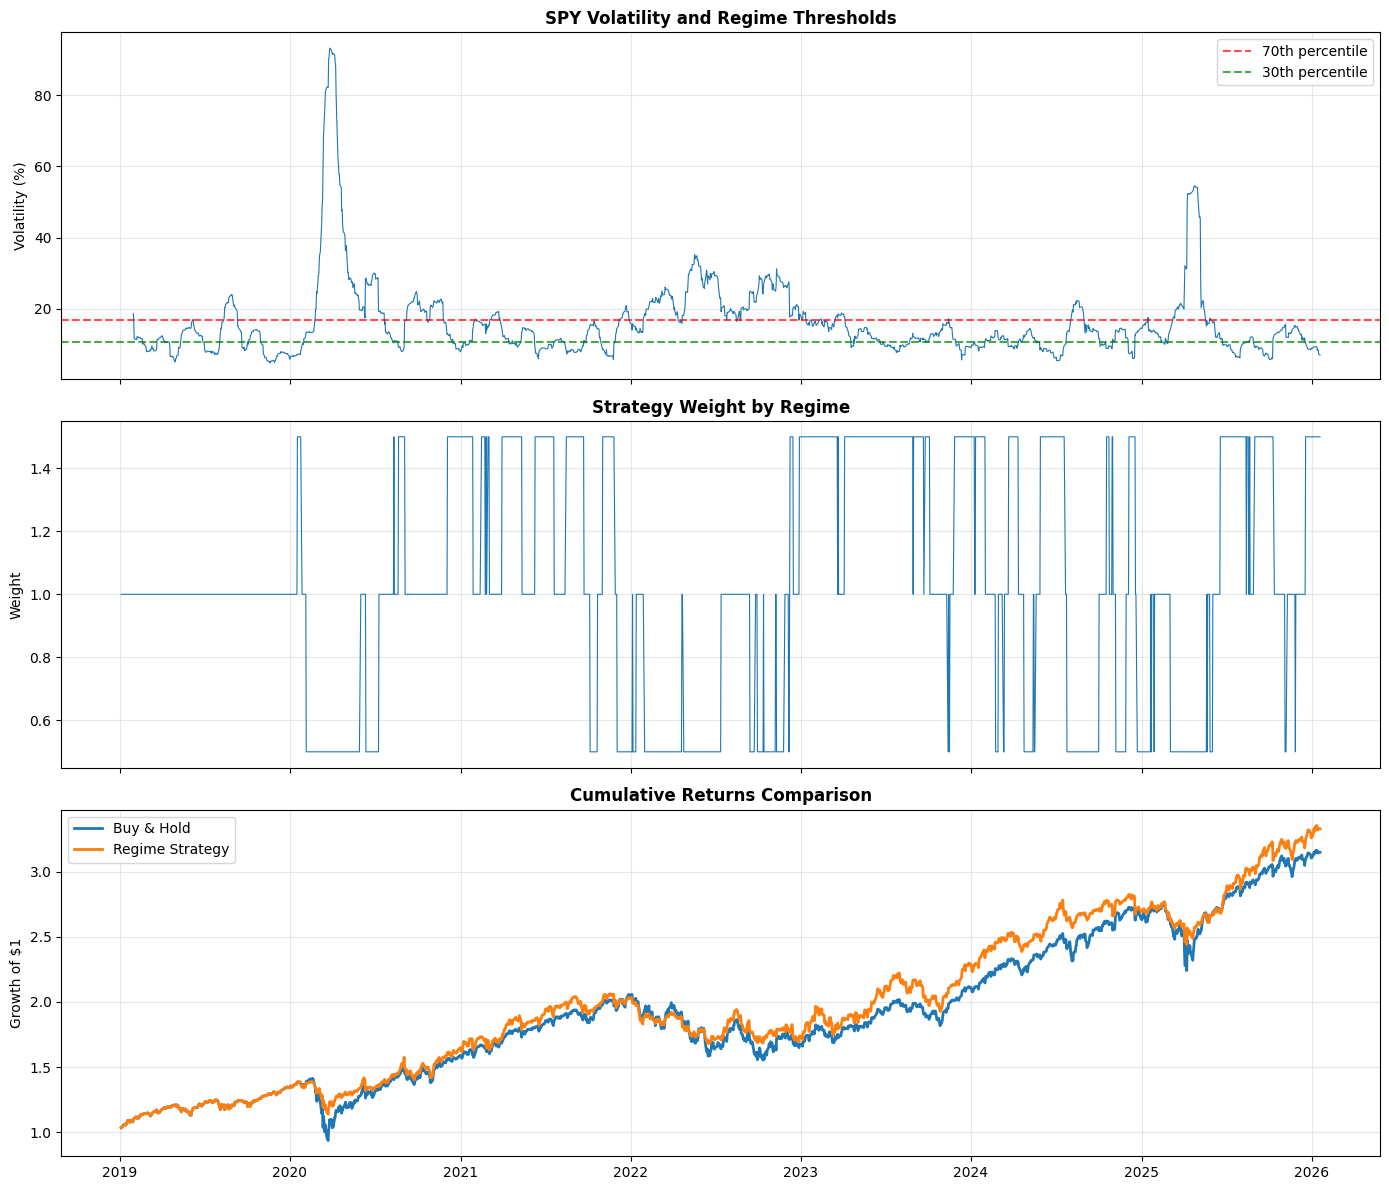

In [7]:
# Plot regime strategy
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

ax1 = axes[0]
ax1.plot(spy_vol * 100, linewidth=0.8)
ax1.axhline(spy_vol.quantile(0.7) * 100, color='red', linestyle='--', alpha=0.7, label='70th percentile')
ax1.axhline(spy_vol.quantile(0.3) * 100, color='green', linestyle='--', alpha=0.7, label='30th percentile')
ax1.set_title('SPY Volatility and Regime Thresholds', fontweight='bold')
ax1.set_ylabel('Volatility (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(weights, linewidth=0.8)
ax2.set_title('Strategy Weight by Regime', fontweight='bold')
ax2.set_ylabel('Weight')
ax2.grid(True, alpha=0.3)

ax3 = axes[2]
ax3.plot((1 + buy_hold_returns).cumprod(), label='Buy & Hold', linewidth=2)
ax3.plot((1 + regime_strategy_returns).cumprod(), label='Regime Strategy', linewidth=2)
ax3.set_title('Cumulative Returns Comparison', fontweight='bold')
ax3.set_ylabel('Growth of $1')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Volatility Targeting

In [8]:
# Target a constant volatility level
target_vol = 0.15  # 15% annualized

# Use GARCH forecast for vol targeting
model = arch_model(spy_returns * 100, vol='GARCH', p=1, q=1)
result = model.fit(disp='off')
garch_vol = result.conditional_volatility * np.sqrt(TRADING_DAYS) / 100

# Calculate leverage to achieve target vol
leverage = target_vol / garch_vol
leverage = leverage.clip(0.25, 2.0)  # Limit leverage

# Shift for no look-ahead bias
leverage = leverage.shift(1)

# Vol-targeted returns
vol_targeted_returns = spy_returns * leverage
vol_targeted_returns = vol_targeted_returns.dropna()
aligned_spy = spy_returns.loc[vol_targeted_returns.index]

print("\n" + "="*60)
print(f"VOLATILITY TARGETING (Target: {target_vol*100:.0f}%)")
print("="*60)

vol_target_results = [
    portfolio_stats(aligned_spy, 'Unlevered SPY'),
    portfolio_stats(vol_targeted_returns, f'Vol Targeted ({target_vol*100:.0f}%)')
]
print(pd.DataFrame(vol_target_results).to_string(index=False))


VOLATILITY TARGETING (Target: 15%)
         Portfolio  Ann. Return (%)  Ann. Vol (%)   Sharpe  Total Return (%)  Max Drawdown (%)
     Unlevered SPY        17.655321     19.363177 0.911799        214.925824        -33.717248
Vol Targeted (15%)        15.829455     15.233353 1.039131        190.484475        -20.527852


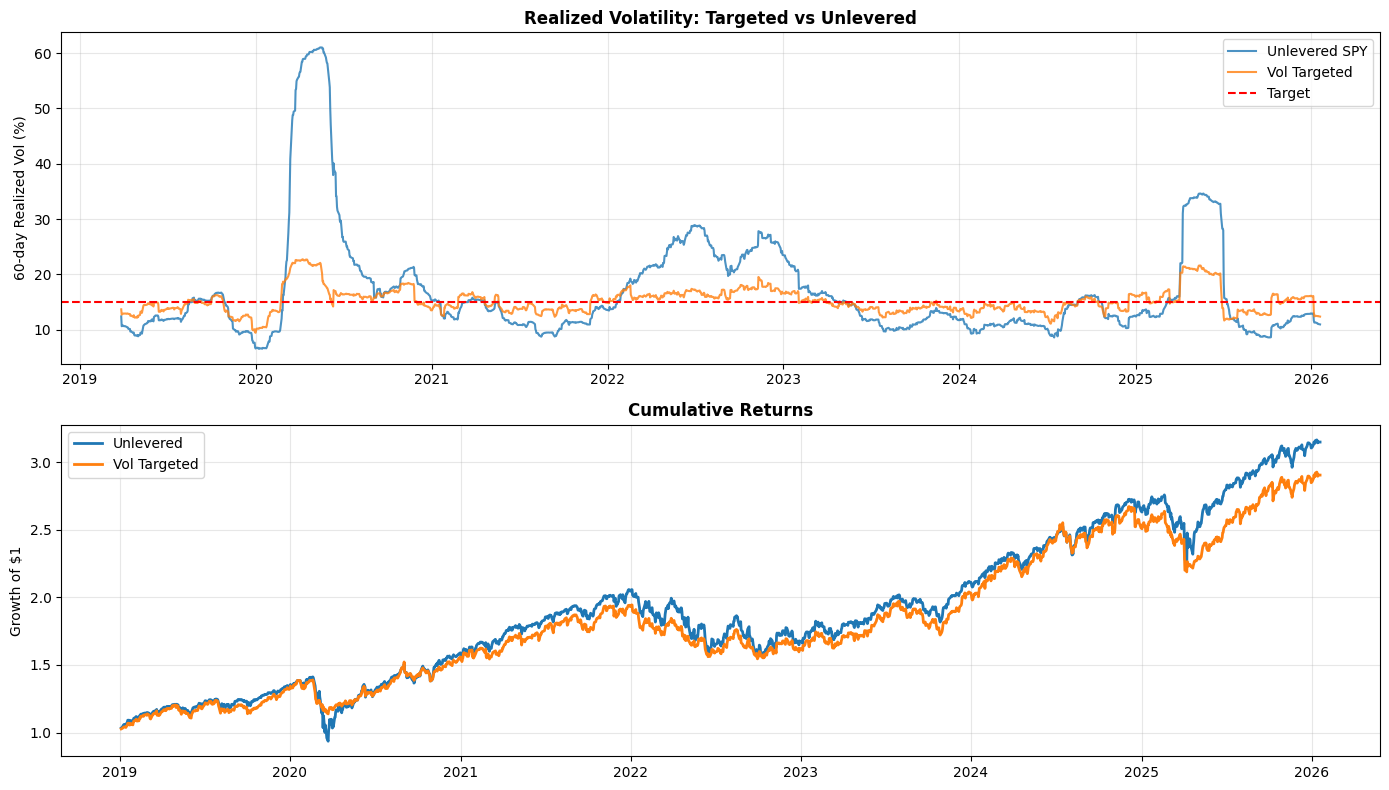

In [9]:
# Compare realized volatility
spy_realized_vol = aligned_spy.rolling(60).std() * np.sqrt(TRADING_DAYS)
targeted_realized_vol = vol_targeted_returns.rolling(60).std() * np.sqrt(TRADING_DAYS)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

ax1 = axes[0]
ax1.plot(spy_realized_vol * 100, label='Unlevered SPY', alpha=0.8)
ax1.plot(targeted_realized_vol * 100, label='Vol Targeted', alpha=0.8)
ax1.axhline(target_vol * 100, color='red', linestyle='--', label='Target')
ax1.set_title('Realized Volatility: Targeted vs Unlevered', fontweight='bold')
ax1.set_ylabel('60-day Realized Vol (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot((1 + aligned_spy).cumprod(), label='Unlevered', linewidth=2)
ax2.plot((1 + vol_targeted_returns).cumprod(), label='Vol Targeted', linewidth=2)
ax2.set_title('Cumulative Returns', fontweight='bold')
ax2.set_ylabel('Growth of $1')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Volatility Risk Premium

In [10]:
# Simulate VRP strategy
# When implied vol > realized vol, sell volatility (go long stocks)
# Here we approximate using GARCH forecast vs realized

# GARCH forecast (proxy for implied)
garch_forecast = garch_vol

# Realized vol
realized_vol = spy_returns.rolling(20).std() * np.sqrt(TRADING_DAYS)

# VRP signal: forecast - realized
vrp = garch_forecast - realized_vol

# Strategy: long when VRP is positive (sell vol = long stocks)
vrp_signal = (vrp > 0).astype(float)
vrp_signal = vrp_signal.shift(1)  # No look-ahead

vrp_returns = spy_returns * vrp_signal
vrp_returns = vrp_returns.dropna()
spy_aligned = spy_returns.loc[vrp_returns.index]

print("\n" + "="*60)
print("VOLATILITY RISK PREMIUM STRATEGY")
print("="*60)

vrp_results = [
    portfolio_stats(spy_aligned, 'Buy & Hold'),
    portfolio_stats(vrp_returns, 'VRP Strategy')
]
print(pd.DataFrame(vrp_results).to_string(index=False))

print(f"\nTime in market: {vrp_signal.mean()*100:.1f}%")


VOLATILITY RISK PREMIUM STRATEGY
   Portfolio  Ann. Return (%)  Ann. Vol (%)   Sharpe  Total Return (%)  Max Drawdown (%)
  Buy & Hold        17.655321     19.363177 0.911799        214.925824        -33.717248
VRP Strategy         8.884466     15.405858 0.576694         74.983714        -31.872677

Time in market: 63.8%


## 5. Strategy Comparison

In [11]:
# Summary of all strategies
print("\n" + "="*70)
print("VOLATILITY STRATEGY SUMMARY")
print("="*70)

all_results = []

# Low vol anomaly
all_results.append(portfolio_stats(low_vol_returns, 'Low Vol Anomaly'))

# Regime strategy
all_results.append(portfolio_stats(regime_strategy_returns, 'Vol Regime'))

# Vol targeting
all_results.append(portfolio_stats(vol_targeted_returns, 'Vol Targeting'))

# VRP
all_results.append(portfolio_stats(vrp_returns, 'VRP'))

summary_df = pd.DataFrame(all_results)
summary_df = summary_df.sort_values('Sharpe', ascending=False)
print(summary_df.to_string(index=False))


VOLATILITY STRATEGY SUMMARY
      Portfolio  Ann. Return (%)  Ann. Vol (%)   Sharpe  Total Return (%)  Max Drawdown (%)
     Vol Regime        17.821253     15.976386 1.115475        232.954683        -18.544857
  Vol Targeting        15.829455     15.233353 1.039131        190.484475        -20.527852
Low Vol Anomaly         6.761877      7.934260 0.852238         57.424989        -15.821005
            VRP         8.884466     15.405858 0.576694         74.983714        -31.872677


## Key Takeaways

1. **Low Volatility Anomaly**: Low vol stocks often have better risk-adjusted returns
2. **Regime Strategies**: Reduce exposure in high vol environments
3. **Volatility Targeting**: Maintains consistent risk exposure over time
4. **VRP Harvesting**: Profit from the premium in implied vs realized vol

### Important Considerations
- **Transaction costs**: Frequent rebalancing can be expensive
- **Leverage limits**: Vol targeting may require leverage
- **Look-ahead bias**: Always shift signals to avoid
- **Regime persistence**: Volatility regimes are somewhat predictable

---
*Next: Day 7 - Interview Questions & Review*